Optimizing GP...
Running MCMC...


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


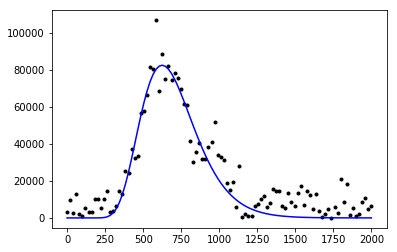

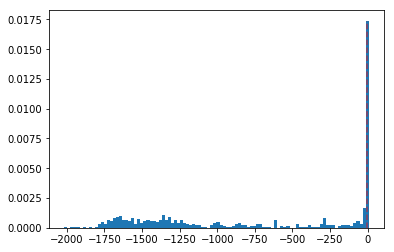

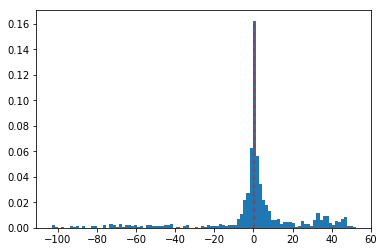

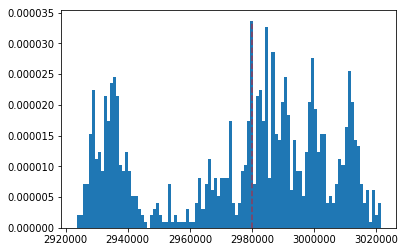

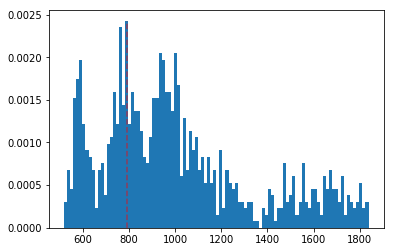

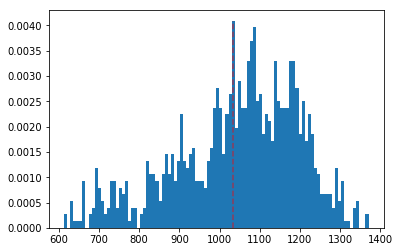

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as ce
import QPP_Funcs as QPP
from scipy.optimize import minimize

params0 = [3.2e+06, 3.9e+03, 1e+02]
x0 = np.linspace(0,2000,100)
y0 = QPP.CTS(x0, params0)
yerr = np.sqrt(y0)

class CTSModel_prior(QPP.CTSModel):
    def log_prior(self):
        Aprob = 0.
        tau1prob = 0.
        tau2prob = 0.
        if(self.A>0 and self.A<3.5e7):
            Aprob = 1./(3.5e7)
        #manually entering length of pulse, needs to be fixed
        T=2000
        if(self.tau1>0 and self.tau1<T):
            tau1prob = 1./T
        if(self.tau2>0 and self.tau2<T):
            tau2prob = 1./T
        return np.log(Aprob * tau1prob * tau2prob)

CTS_Model = CTSModel_prior(A=3e6, tau1 = 1e3, tau2= 1e3)

kernel = ce.terms.RealTerm(log_a = np.log(1e3), log_c = np.log(1e3))
gp = ce.GP(kernel, mean=CTS_Model, fit_mean=True)

gp.compute(x0, yerr)
x,y = QPP.simulate(x0, params0, QPP.CTS, kernel = gp.get_matrix())
x,y= zip(*sorted(zip(x,y)))
gp.compute(x, yerr)

plt.plot(x,y, 'k.')
plt.plot(x0, y0, 'b-')

#defining cost function:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):   
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

print "Optimizing GP..."
initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like, method ="L-BFGS-B", args = (y, gp))

yfinalgp = QPP.CTS(x0, [soln.x[2], soln.x[3], soln.x[4]])

#reset and test with MH MCMC
gp.set_parameter_vector(initial_params)
def samplepdf(params):
    return np.random.normal(loc=params, scale=np.sqrt(np.abs(params)))

def MCMCStep(gp, params, y, q, lfunc):
    newparams = q(params)
    r = np.random.rand()
    prob1 = lfunc(gp, y)
    gp.set_parameter_vector(newparams)
    prob2 = lfunc(gp, y)
    if(prob2-prob2==prob2):
        return newparams
    if((prob2/prob1)>r):
        return newparams
    else:
        gp.set_parameter_vector(params)
        return params

def post_likelihood(gp, y):
    log_like = gp.log_likelihood(y)
    log_prior = gp.log_prior()
    result = log_like+log_prior
    if(np.isfinite(result)):
        return result
    else:
        return 0 
    
    
N = int(1e3)
paramset=np.empty([N,5])
paramset[0] = initial_params
print "Running MCMC..."
for i in range(N-1):
    try:
        paramset[i+1] = MCMCStep(gp, paramset[i], y, samplepdf, post_likelihood)
    except(RuntimeError):
        i-=1
        
plt.figure()
Ahist, Abins, Apatches = plt.hist(paramset[:,0], normed=1, bins=100)
Ain = np.argmax(Ahist)
AMax = np.average([Abins[Ain], Abins[Ain+1]])
Ax = AMax * np.ones(100)
Ay = np.linspace(0, max(Ahist), 100)
plt.plot(Ax, Ay, 'r--', alpha=0.5)

plt.figure()
chist, cbins, cpatches = plt.hist(paramset[:,1], normed=1, bins=100)
cin = np.argmax(chist)
cMax = np.average([cbins[cin], cbins[cin+1]])
cx = cMax * np.ones(100)
cy = np.linspace(0, max(chist), 100)
plt.plot(cx, cy, 'r--', alpha=0.5)

plt.figure()
ahist, abins, apatches = plt.hist(paramset[:,2], normed=1, bins=100)
ain = np.argmax(ahist)
aMax = np.average([abins[ain], abins[ain+1]])
ax = aMax * np.ones(100)
ay = np.linspace(0, max(ahist), 100)
plt.plot(ax, ay, 'r--', alpha=0.5)

plt.figure()
t1hist, t1bins, t1patches = plt.hist(paramset[:,3], normed=1, bins=100)
t1in = np.argmax(t1hist)
t1Max = np.average([t1bins[t1in], t1bins[t1in+1]])
t1x = t1Max * np.ones(100)
t1y = np.linspace(0, max(t1hist), 100)
plt.plot(t1x, t1y, 'r--', alpha=0.5)

plt.figure()
t2hist, t2bins, t2patches = plt.hist(paramset[:,4], normed=1, bins=100)
t2in = np.argmax(t2hist)
t2Max = np.average([t2bins[t2in], t2bins[t2in+1]])
t2x = t2Max * np.ones(100)
t2y = np.linspace(0, max(t2hist), 100)
plt.plot(t2x, t2y, 'r--', alpha=0.5)

plt.show()

In [ ]:
yfinalMCMC = QPP.CTS(x0, [aMax, t1Max, t2Max])

print params0
print soln.x[2:]
print [aMax, t1Max, t2Max]

plt.plot(x0, y0, 'b-')
plt.plot(x, y, 'k.')
plt.plot(x0, yfinalgp, 'r-')
plt.plot(x0, yfinalMCMC, 'g-')
plt.show()